In [1]:
import rasterio

# Paths to your TIFF files
tif_POST = '/Volumes/SSD PERDECK/GLCM clipped/GLCM POST.tif'
tif_PRE = '/Volumes/SSD PERDECK/GLCM clipped/GLCM PRE.tif'

# Function to print band information for a TIFF file
def print_band_info(tif_file):
    with rasterio.open(tif_file) as src:
        print(f"Information for: {tif_file}")
        print(f"Number of bands: {src.count}")
        for i in range(1, src.count + 1):
            band = src.read(i)
            print(f"Band {i} shape: {band.shape}")
        print("-" * 40)

# Print band information for each TIFF file
print_band_info(tif_PRE)
print_band_info(tif_POST)


Information for: /Volumes/SSD PERDECK/GLCM clipped/GLCM PRE.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------
Information for: /Volumes/SSD PERDECK/GLCM clipped/GLCM POST.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------


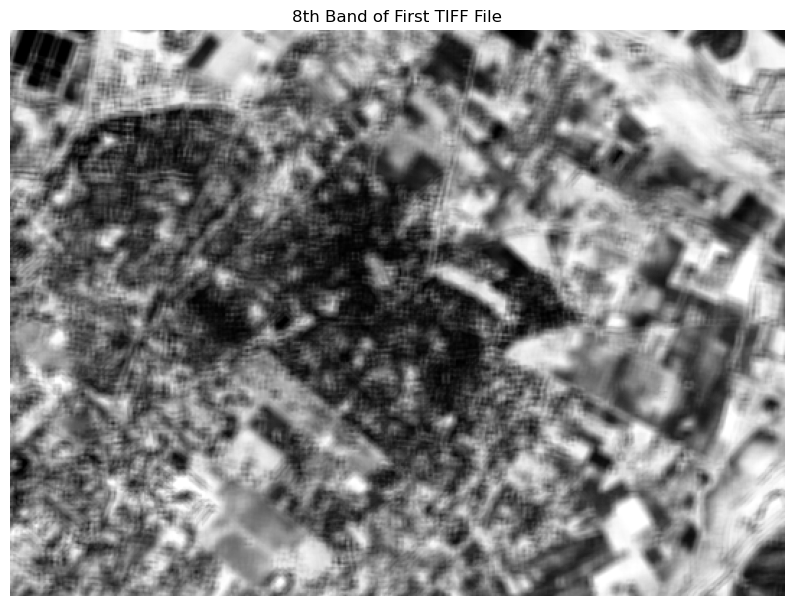

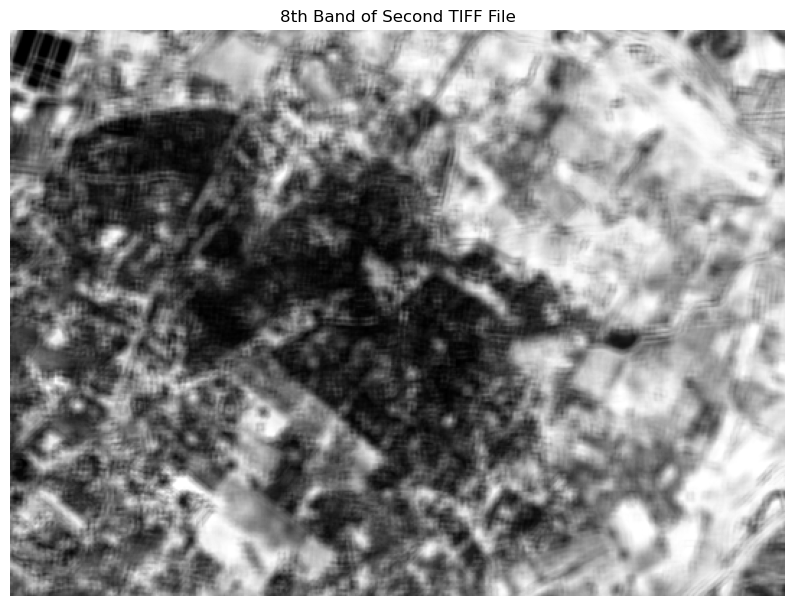

In [2]:
import matplotlib.pyplot as plt

# Function to read and display the 8th band of a TIFF file
def display_band_8(tif_file, title):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < 8:
            print(f"File {tif_file} does not have 8 bands.")
            return
        # Read the 8th band
        band_8 = src.read(8)

        # Display the image
        plt.figure(figsize=(10, 10))
        plt.imshow(band_8, cmap='gray')
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()

# Display the 8th band for each TIFF file
display_band_8(tif_PRE, "8th Band of First TIFF File")
display_band_8(tif_POST, "8th Band of Second TIFF File")

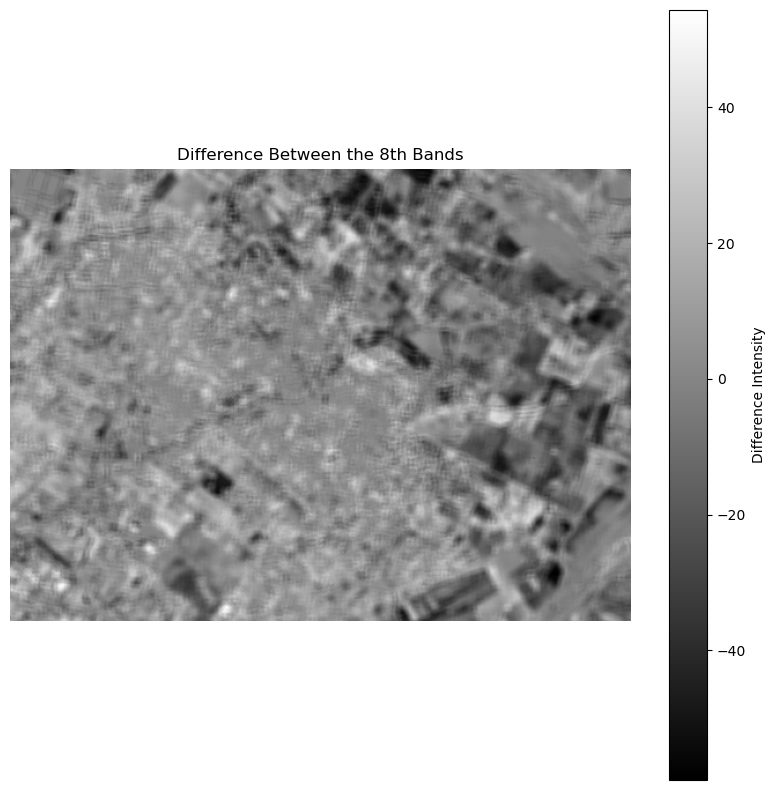

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# Paths to your TIFF files
tif_file_1 = 'path/to/your/first.tif'
tif_file_2 = 'path/to/your/second.tif'

# Function to read the 8th band of a TIFF file
def read_band_8(tif_file):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < 8:
            print(f"File {tif_file} does not have 8 bands.")
            return None
        # Read the 8th band
        band_8 = src.read(8)
        return band_8

# Read the 8th band from both files
band_8_1 = read_band_8(tif_PRE)
band_8_2 = read_band_8(tif_POST)

if band_8_1 is not None and band_8_2 is not None:
    # Check if the bands have the same shape
    if band_8_1.shape != band_8_2.shape:
        print("The 8th bands of the two files do not have the same shape.")
    else:
        # Compute the difference
        difference = band_8_1 - band_8_2
        

        # Display the difference image
        plt.figure(figsize=(10, 10))
        plt.imshow(difference, cmap='gray')
        plt.title("Difference Between the 8th Bands")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Difference Intensity')  # Show a color bar indicating the difference intensity
        plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# Paths to your TIFF files
tif_file_1 = '/Volumes/SSD PERDECK/GLCM clipped/GLCM PRE.tif'
tif_file_2 = '/Volumes/SSD PERDECK/GLCM clipped/GLCM POST.tif'

# Function to read the 8th band of a TIFF file
def read_band_8(tif_file):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < 8:
            print(f"File {tif_file} does not have 8 bands.")
            return None
        # Read the 8th band
        band_8 = src.read(8)
        return band_8

# Read the 8th band from both files
band_8_1 = read_band_8(tif_file_1)
band_8_2 = read_band_8(tif_file_2)

if band_8_1 is not None and band_8_2 is not None:
    # Check if the bands have the same shape
    if band_8_1.shape != band_8_2.shape:
        print("The 8th bands of the two files do not have the same shape.")
    else:
        # Compute the difference
        difference = band_8_1 - band_8_2

        # Display the difference image
        plt.figure(figsize=(10, 10))
        plt.imshow(difference, cmap='gray')
        plt.title("Difference Between the 8th Bands")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Difference Intensity')  # Show a color bar indicating the difference intensity
        plt.show()

        # Save the difference image
        # Use the metadata of the first file as a template for the output file
        with rasterio.open(tif_file_1) as src:
            meta = src.meta

        # Update the metadata to reflect that we have only 1 band
        meta.update(count=1)

        # Define the path for the output difference TIFF file
        output_tif = 'difference_image.tif'

        # Write the difference image to a new TIFF file
        with rasterio.open(output_tif, 'w', **meta) as dst:
            dst.write(difference, 1)

        print(f"Difference image saved to: {output_tif}")


In [ ]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the difference image
with rasterio.open('difference_image.tif') as src:
    difference_image = src.read(1)  # Assuming the difference is in the first band
    difference_affine = src.transform

# Load the shapefile with geopandas
shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

# Rasterize the shapefile
from rasterio.features import rasterize

def rasterize_shapefile(shapefile, affine, shape):
    # Convert the 'damaged' column to integer type
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=0, all_touched=True, dtype=rasterio.uint8)
    return rasterized

rasterized_shapefile = rasterize_shapefile(shapefile, difference_affine, difference_image.shape)

# Function to compute accuracy at different thresholds
def compute_accuracy_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    for threshold in thresholds:
        # Apply threshold to difference image to classify as damaged (1) or not damaged (0)
        classified_image = np.where(difference_image > threshold, 1, 0)

        # Calculate accuracy
        accuracy = accuracy_score(rasterized_shapefile.flatten(), classified_image.flatten())
        print(f"Threshold: {threshold}, Accuracy: {accuracy}")
        
        # Display the classified map
        plt.figure(figsize=(10, 10))
        plt.imshow(classified_image, cmap='gray')
        plt.title(f"Classified Map at Threshold: {threshold}, Accuracy: {accuracy}")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Classification')  # Show a color bar indicating classification
        plt.show()

# Define a range of threshold values to test
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
# Compute accuracy for each threshold
compute_accuracy_at_thresholds(difference_image, rasterized_shapefile, thresholds)


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the difference image
with rasterio.open('difference_image.tif') as src:
    difference_image = src.read(1)  # Assuming the difference is in the first band
    difference_affine = src.transform

# Load the shapefile with geopandas
shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

# Rasterize the shapefile
def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=0, all_touched=True, dtype=rasterio.uint8)
    return rasterized

rasterized_shapefile = rasterize_shapefile(shapefile, difference_affine, difference_image.shape)

# Function to compute accuracy and other metrics at different thresholds
def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    for threshold in thresholds:
        # Apply threshold to the entire difference image to classify as damaged (1) or not damaged (0)
        classified_image = np.where(difference_image > threshold, 1, 0)

        # Mask the classified image to only include building areas
        masked_classified_image = np.where(rasterized_shapefile == 1, classified_image, np.nan)

        # Flatten arrays and remove np.nan values for metrics calculation
        true_values = rasterized_shapefile.flatten()
        predicted_values = masked_classified_image.flatten()
        valid_mask = ~np.isnan(predicted_values)
        true_values = true_values[valid_mask]
        predicted_values = predicted_values[valid_mask]

        # Calculate metrics, ensuring to only consider non-nan values
        accuracy = accuracy_score(true_values, predicted_values)
        precision = precision_score(true_values, predicted_values)
        recall = recall_score(true_values, predicted_values)
        f1 = f1_score(true_values, predicted_values)

        print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        # Display the masked classified map to visualize classification within building polygons
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_classified_image, cmap='gray', vmin=0, vmax=1)  # Set color scale to cover [0, 1] for clarity
        plt.title(f"Map at Threshold: {threshold:.2f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        plt.axis('off')
        plt.colorbar(label='Classification')
        plt.show()


# Define a range of threshold values to test
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
# Compute metrics for each threshold
compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)
